# A Study on Generalized Item Based Filtering using SVD

In [126]:
import pandas as pd 
import numpy as np
import csv
import math
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


## Purpose

Our proposed algorithm for the following code utlized the first experiment in the article 

### Data Collection and Cleaning

In [127]:
#Data file containing ratings data
f = open("data/u.data")
text = csv.reader(f, delimiter = "\t")
ratings = list(text)

#Data containing Item Data (Content)
f = open("data/u.item")
text = csv.reader(f, delimiter = "|")
item = list(text)


ratings_pd = pd.DataFrame(ratings, columns = ["user_id","movie_id", "rating","timestamp"])
ratings_pd = ratings_pd.drop(["timestamp"], 1)

movies = ratings_pd.pivot(index = "user_id", columns = "movie_id", values = "rating")
movies_test = movies
movies_test = movies.apply(pd.to_numeric, errors='coerce')
movies = movies.apply(pd.to_numeric, errors='coerce')
movies_int = np.array(movies)
np.nan_to_num(movies_int)

# Borrowed some code here from Padebetttu et. al. -DATA643- Project 2
user_mean = movies.T.mean(skipna=True)
item_mean = movies.mean(skipna=True)
movies = movies.apply(lambda x: x.fillna(x.mean(skipna = True)),axis=1)
movies_mean = movies.apply(lambda x: x-x.mean(), axis = 1).round(5)


### Using SVD to Determine an appropriate *k* Value

In [128]:
#Using SVD to find 
movies_np = np.array(movies_mean)
movies_np = movies_np.astype(float)


def svd_red(movies_mean,n):
    U1, s1, V1 = np.linalg.svd(movies_mean, full_matrices=True)
    k = np.zeros((len(s1),len(s1)),float)
    np.fill_diagonal(k,s1)
    k = k[:n,:n]
    k = np.sqrt(k)
    U2 = U1[:,:n]
    V2 =V1[:,:n].T
    Uk = np.dot(U2,k.T)
    Vk = np.dot(k,V2)
    R_red = np.dot(Uk,Vk)
    return R_red, Uk, Vk

def pred_item(movies_mean,n):
    R_red, Uk, Vk = svd_red(movies_mean,n)
    item_similarity = 1 - pairwise_distances(Vk.T, metric='cosine')
    pred = R_red.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])  
    final_pred = pred.T
    final_pred += user_mean
    final_pred = final_pred.T
    return final_pred


Using the above code we are able to find a prediction based on the Item-Item Collaborative Filter using SVD. To test various values of K to determine if the k by k reduced matrix size greatly influence the Error, we can calculate the Root Mean Square Error over several changes in k. 

In [129]:
RMSE = []

k = [1,2,3,4,5,10,20,30,40,50,100,200,300,400,500]

for i in k:
    pred = pred_item(movies_mean, i)
    y = mean_squared_error(movies_int[np.where(movies_int >0)], pred[np.where(movies_int >0)])   
    RMSE.append(math.sqrt(y))

Ploting the Error gives us a better representation of the error that betweeen the actual predicted values: 

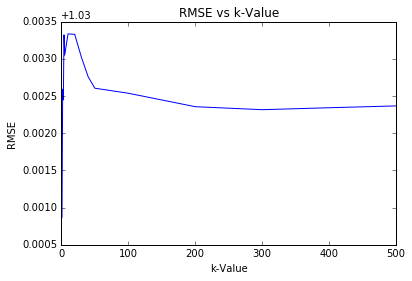

In [130]:
%matplotlib inline
plt.plot(k, RMSE)
plt.title("RMSE vs k-Value")
plt.ylabel('RMSE')
plt.xlabel("k-Value")
plt.show()

From our investigation, the k-value makes very little difference in the overall error, as it is very likely that vast number of data points will not result in a significant difference. However the above graph allows for us to pick a suitable k value to minimize computation will still maintain an accuracy. On a side note: very low k values actually produced error ratings much lower than the choosen k = 50 for the remainder of the project. It can be assumed that the SVD actually over simplifies at those low values producing lower error but less accurate predictions. We will test this by checking the values of a small sample from each. 

In [131]:
index = movies.index.tolist()
columns = list(movies.columns.values)
pred = pred_item(movies_mean, 50)
Pred_pd = pd.DataFrame(pred, index = index, columns=columns)

i = ['56','64','71','94','102','118','173','196','928','651','514','483','432','404']
movies_sm = movies_test.loc[i,:]
Pred_sm = Pred_pd.loc[i,:]

l = ['13','201','222','234','246','268','269','276','655','95','194']
movies_sm = movies_sm.loc[:,l]
Pred_sm = Pred_sm.loc[:,l]


In [132]:
movies_sm

movie_id,13,201,222,234,246,268,269,276,655,95,194
user_id,,,,,,,,,,,
56,NaN,4,5,4,NaN,NaN,NaN,NaN,4,4,5
64,NaN,NaN,4,4,NaN,NaN,5,NaN,4,4,5
71,NaN,NaN,3,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN
94,NaN,4,3,5,4,4,NaN,NaN,4,NaN,4
102,3,2,3,3,NaN,NaN,2,NaN,3,4,3
118,NaN,5,NaN,5,NaN,NaN,NaN,NaN,5,NaN,NaN
173,NaN,NaN,NaN,NaN,NaN,4,4,NaN,NaN,NaN,NaN
196,2,NaN,NaN,NaN,NaN,NaN,3,NaN,5,NaN,NaN
928,NaN,NaN,NaN,NaN,5,5,5,5,NaN,NaN,NaN


In [133]:
Pred_sm

,13,201,222,234,246,268,269,276,655,95,194
56,3.638841,3.667924,3.625895,3.614092,3.655007,3.633588,3.684443,3.680969,3.675573,3.684488,3.662939
64,3.665280,3.551540,3.560381,3.581006,3.513776,3.563380,3.607967,3.596407,3.597078,3.585890,3.636541
71,3.809453,3.777428,3.789493,3.783826,3.769478,3.793239,3.797251,3.778241,3.787572,3.792971,3.790046
94,3.883329,3.609355,3.702943,3.596206,3.607168,3.620851,3.782853,3.628095,3.610609,3.611710,3.665110
102,2.625282,2.640950,2.573871,2.618690,2.617193,2.616008,2.598835,2.616808,2.586358,2.632799,2.629014
118,4.670194,4.663098,4.654940,4.666172,4.654705,4.648415,4.672764,4.672513,4.652272,4.669450,4.670847
173,4.220472,4.195182,4.215370,4.210471,4.198393,4.206932,4.210457,4.211159,4.229208,4.200487,4.209021
196,3.624134,3.619633,3.613577,3.615265,3.619556,3.619222,3.618341,3.612044,3.611121,3.610914,3.613759
928,4.705683,4.673593,4.688602,4.667573,4.682280,4.696420,4.690517,4.668001,4.687336,4.691319,4.686483
651,3.291638,3.261004,3.260140,3.278090,3.257495,3.272148,3.307492,3.298788,3.302877,3.248714,3.278352


In [139]:
pred_sm = np.array(Pred_sm)
movies_sm = np.array(movies_sm)
movies_sm = np.nan_to_num(movies_sm)

movies_sm
y = mean_squared_error(movies_sm[np.where(movies_sm >0)], pred_sm[np.where(movies_sm >0)])   
math.sqrt(y)

0.7140570927100709

### References

Vozalis M., Margaritis K.; *Applying SVD on Generalized Item-based Filtering* International Journal of Computer Science & Applications 2006; Vol.3 Is.3, pp 27- 51 2006 http://www.tmrfindia.org/ijcsa/v3i34.pdf

F. Maxwell Harper and Joseph A. Konstan. 2015. *The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4, Article 19 (December 2015), 19 pages. http://dx.doi.org/10.1145/2827872 http://grouplens.org/datasets/movielens/